## Objectif

L’objectif de ce notebook est d’évaluer la **faisabilité d’une classification automatique des produits**
à partir de leur **description textuelle uniquement**, sans apprentissage supervisé.

La faisabilité sera évaluée via :
- une représentation vectorielle des descriptions,
- une réduction de dimension en 2D,
- une visualisation des produits colorés par leur catégorie réelle,
- un clustering non supervisé (KMeans),
- et le calcul de l’Adjusted Rand Index (ARI).


In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aurelien/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/aurelien/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:


df = pd.read_csv("../data/Flipkart/flipkart_com-ecommerce_sample_1050.csv")

# Sélection des colonnes utiles
df = df[["product_name", "description", "product_category_tree"]]

# Extraction de la catégorie principale
df["category"] = df["product_category_tree"].apply(
    lambda x: x.split(">>")[0].replace("[\"", "").strip()
)

df.head()


,product_name,description,product_category_tree,category
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,"[""Home Furnishing >> Curtains & Accessories >>...",Home Furnishing
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Home Furnishing
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Home Furnishing


In [3]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = text.split()
    tokens = [
        lemmatizer.lemmatize(tok)
        for tok in tokens
        if tok not in stop_words and len(tok) > 2
    ]
    return " ".join(tokens)

df["text"] = (df["product_name"] + " " + df["description"]).apply(clean_text)
df[["product_name", "text"]].head()


,product_name,text
0,Elegance Polyester Multicolor Abstract Eyelet ...,elegance polyester multicolor abstract eyelet ...
1,Sathiyas Cotton Bath Towel,sathiyas cotton bath towel specification sathi...
2,Eurospa Cotton Terry Face Towel Set,eurospa cotton terry face towel set key featur...
3,SANTOSH ROYAL FASHION Cotton Printed King size...,santosh royal fashion cotton printed king size...
4,Jaipur Print Cotton Floral King sized Double B...,jaipur print cotton floral king sized double b...


In [4]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)
)

X_tfidf = tfidf.fit_transform(df["text"])
y = df["category"]

X_tfidf.shape


(1050, 5000)

In [5]:
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

X_pca.shape


(1050, 50)

In [6]:
tsne = TSNE(
    n_components=2,
    perplexity=30,
    random_state=42,
    init="pca"
)

X_tsne = tsne.fit_transform(X_pca)
X_tsne.shape


(1050, 2)

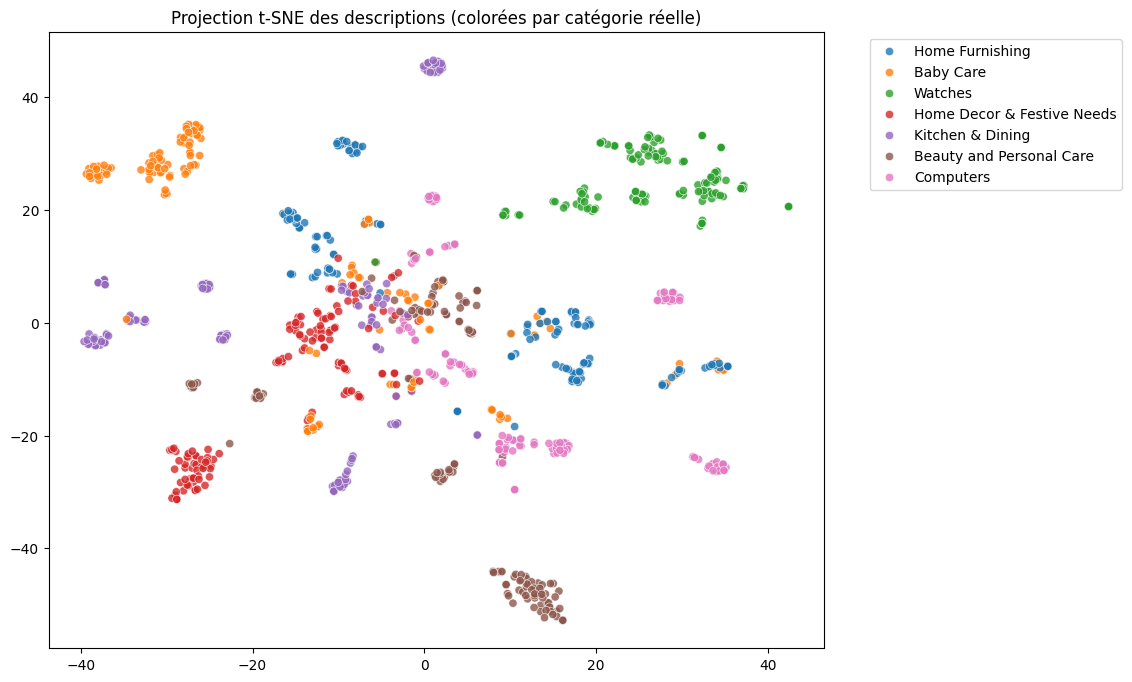

In [7]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=y,
    palette="tab10",
    alpha=0.8
)
plt.title("Projection t-SNE des descriptions (colorées par catégorie réelle)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


In [8]:
kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(X_tsne)

ari = adjusted_rand_score(y, clusters)
ari


0.3230994303233914

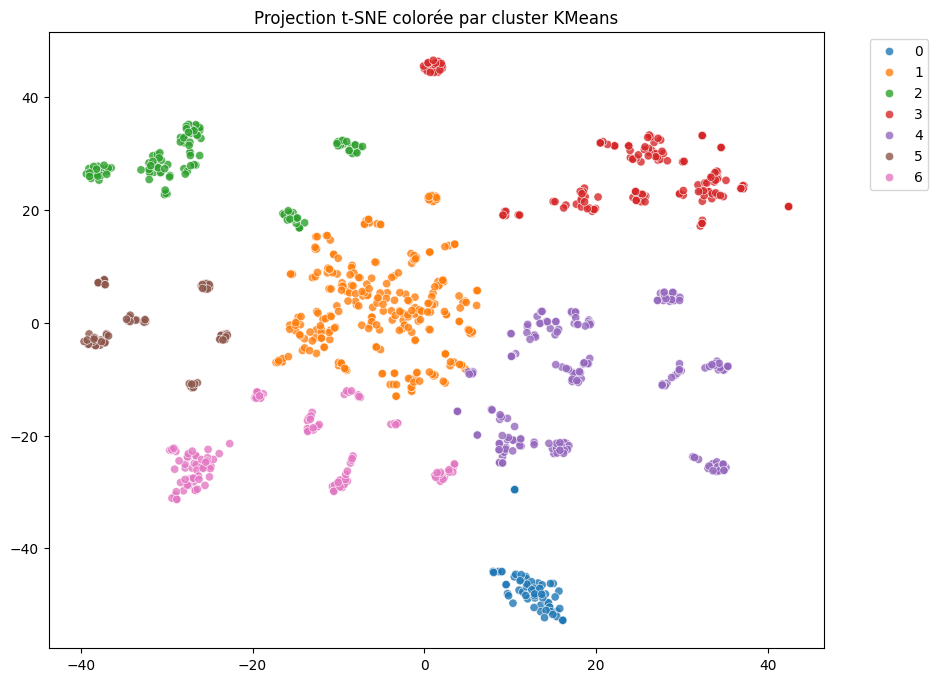

In [9]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=clusters,
    palette="tab10",
    alpha=0.8
)
plt.title("Projection t-SNE colorée par cluster KMeans")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


## Conclusion

Les visualisations t-SNE montrent une **séparation partielle mais nette** des produits
selon leur catégorie réelle, uniquement à partir des descriptions textuelles.

Le clustering KMeans appliqué sur la projection 2D confirme cette observation,
avec un Adjusted Rand Index d’environ {:.2f}.

Ces résultats valident la **faisabilité d’une classification automatique des produits
à partir du texte**, ce qui justifie la poursuite du projet avec des approches plus avancées.
```.format(ari)
